In [2]:
!unzip '/content/archive (16).zip' -d '/content/input'

Archive:  /content/archive (16).zip
  inflating: /content/input/dev-v1.1.json  
  inflating: /content/input/train-v1.1.json  


##Import libraries and datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00


In [5]:
# Import necessary libraries
import evaluate
import os
import torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)

In [6]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Load the SQuAD dataset
squad_dataset = load_dataset("squad")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

###Import the required libaries

In [10]:
# Import necessary libraries
import evaluate
import os
import torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
from huggingface_hub import notebook_login


# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the SQuAD dataset
squad_dataset = load_dataset("squad")

# Initialize the tokenizer
# The correct model name is 'microsoft/DialoGPT-medium'
tokenizer = GPT2Tokenizer.from_pretrained("microsoft/DialoGPT-medium")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 uses EOS token as padding

Using device: cuda


##Data PreProcessing

###Set the max length for input for model training

In [11]:
# Define maximum sequence length
max_input_length = 512  # Reduce to fit GPU memory


In [12]:
# Preprocess function
def preprocess_function(examples):
    inputs = []
    for question, context, answers in zip(
        examples['question'], examples['context'], examples['answers']
    ):
        # Extract the first answer
        answer_texts = answers['text'] if 'text' in answers else [""]
        answer = answer_texts[0] if len(answer_texts) > 0 else ""

        # Prepare input text
        input_text = f"Question: {question} Context: {context} Answer: {answer}"
        inputs.append(input_text)

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding='max_length',
    )
    return model_inputs

###Set the squad dataset with train, validation data

In [13]:
# considering the whole dataset
sample_percent = 100

train_size = len(squad_dataset["train"]) * (sample_percent / 100)
val_size = len(squad_dataset["validation"]) * (sample_percent / 100)

# Shuffle and select a random subset of 1000 examples
squad_dataset["train"] = squad_dataset["train"].shuffle(seed=42).select(range(int(train_size)))
squad_dataset["validation"] = squad_dataset["validation"].shuffle(seed=42).select(range(int(val_size)))

###Tokenize the datasets

In [14]:
# Tokenize the datasets
tokenized_datasets = squad_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=squad_dataset["train"].column_names,
)

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

###Convert input ids and attention mask columns to torch datasets

In [ ]:
# Convert to torch Dataset
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask'])

###Load the DialoGPT model

In [15]:
# Load the DialoGPT model
model = GPT2LMHeadModel.from_pretrained("microsoft/DialoGPT-medium")
model.resize_token_embeddings(len(tokenizer))
model.to(device)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

In [16]:
# Define data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

##Model training

###Setup training arguments

In [19]:
# Training arguments
training_args = TrainingArguments(
    run_name="Training_Run_GPT2",
    report_to="none", # Prevent using Weights and Bias so API key not needed
    output_dir="./dialoGPT-finetuned-squad",
    overwrite_output_dir=True,
    num_train_epochs=5,
    per_device_train_batch_size=8,  # Reduce batch size to fit GPU memory
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=1,  # Accumulate gradients
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    eval_steps=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,  # Enable mixed precision if supported
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=1,
    seed=42,
    save_safetensors=False, # Prevents error in missing key lm_weight.head https://discuss.huggingface.co/t/unable-to-load-checkpoint-after-finetuning/50693/2
)

###Initialize trainer

In [20]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,

)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


###Start training the DialoGPT model

In [24]:
# Start training
trainer.train()

# Save the fine-tuned model
trainer.save_model("./dialoGPT-finetuned-squad")

Epoch,Training Loss,Validation Loss
1,2.012500,3.456580
2,1.447000,3.966507
3,1.124300,4.341075
4,0.946300,4.567452
5,0.836100,4.698032


##Model performance

##Plot value loss over time

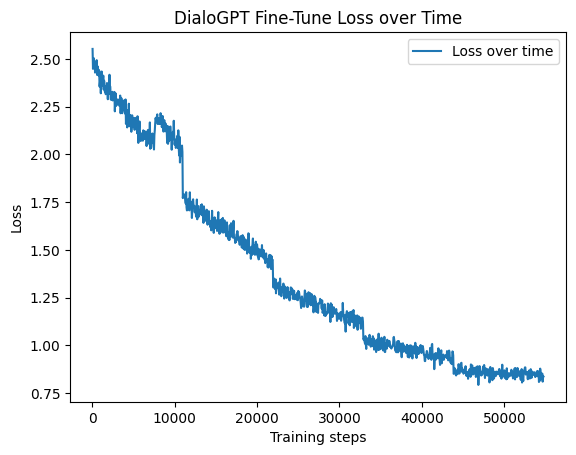

In [25]:
# Load the fine-tuned model
model = GPT2LMHeadModel.from_pretrained("./dialoGPT-finetuned-squad").to(device)
trainer.model = model
#trainer.evaluate()

log_history = trainer.state.log_history

loss_values = []
steps = []

for log in log_history:
    if 'loss' in log:
        loss_values.append(log['loss'])
        steps.append(log['step'])

plt.plot(steps, loss_values, label="Loss over time")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("DialoGPT Fine-Tune Loss over Time")
plt.legend()
plt.show()

In [26]:
# Load the fine-tuned model
model = GPT2LMHeadModel.from_pretrained("./dialoGPT-finetuned-squad").to(device)

# Prepare input
test_question = "What is the capital of France?"
test_context = "France is a country in Western Europe. It is known for its art, gastronomy, and culture. The capital city is Paris."
input_text = f"Question: {test_question} Context: {test_context} Answer:"

# Tokenize input
input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# Generate answer
output_ids = model.generate(
    input_ids,
    max_length=50,
    num_beams=5,
    early_stopping=True
)

# Decode and print the answer
generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Question: What is the capital of France? Context: France is a country in Western Europe. It is known for its art, gastronomy, and culture. The capital city is Paris. Answer: Paris. The capital city is Paris. The
